In [2]:
from web3 import Web3
import json
import requests
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from time import *
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go
import math
import warnings
import scipy.stats
import random

## Approach

**Question 1**: Is the decline in participation rate in any correlated to the increase in number of orphaned blocks?
- Look at the trend for participation rate, the trend for oprhaned blocks and notice any correlation 
- Also analyze the attestation count (This might be handy in any firther investigation/hypthesis)

**Question 2**: Is the small drop in a consistent subset of validators? or more evenly distributed?
- Pick 5 major staking entities: Lido, Kraken, Binance, Bitcoin Suisse, Stkr and select 1000 random validators that belong to these entities
- Compare and contrast the performance of these 1000 validators 
- Select 1000 other random validators from a mixed pool and notice the performance of those 1000 validators


## Question 1

### Data collection

In [2]:
#Epoch range: 60000 - 63370

attestor_slashing = {}
proposer_slashing = {}
proposed_block_count = {}
global_participation_rate = {}
exit_counts = {}
deposits = {}
attestation_count = {}
orphaned_blocks = {}

In [4]:
# with open('api_key.txt', 'r') as api_file:
#     api_key = api_file.read()

for epoch in range(60000,63370):
    x = requests.get('https://beaconcha.in/api/v1/epoch/{}?api_key={}'.format(epoch, api_key))
    #Add a sleep to stay within the call rate limits
    sleep(6)
    
    data = x.json()['data']
    
    attestor_slashing[epoch] = data['attesterslashingscount']
    proposer_slashing[epoch] = data['proposerslashingscount']
    proposed_block_count[epoch] = data['proposedblocks']
    global_participation_rate[epoch] = data['globalparticipationrate']
    exit_counts[epoch] = data['voluntaryexitscount']
    deposits[epoch] = data['depositscount']
    attestation_count[epoch] = data['attestationscount']
    orphaned_blocks[epoch] = data['orphanedblocks']

In [5]:
#Writing the dictionaries to csv files

with open('attestor_slashing.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in attestor_slashing.items():
        wr.writerow([key,value])
        
with open('proposer_slashing.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in proposer_slashing.items():
        wr.writerow([key,value])
        
with open('proposed_block_count.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in proposed_block_count.items():
        wr.writerow([key,value])
        
with open('global_participation_rate.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in global_participation_rate.items():
        wr.writerow([key,value])
        
with open('exit_counts.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in exit_counts.items():
        wr.writerow([key,value])
        
with open('deposits.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in deposits.items():
        wr.writerow([key,value])
        
with open('attestation_count.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in attestation_count.items():
        wr.writerow([key,value])
        
with open('orphaned_blocks.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for key, value in orphaned_blocks.items():
        wr.writerow([key,value])

In [3]:
files = ["attestor_slashing", "proposer_slashing", "proposed_block_count", "global_participation_rate", "exit_counts", "deposits", "attestation_count", "orphaned_blocks"]
dfs = []

for file in files:
    df = pd.read_csv(f"{file}.csv", header=None, names=["epoch", file])
    df.dropna(subset=["epoch"], inplace=True)
    dfs += [df[[file]]] # We don't want the epoch column

df = pd.concat([df[["epoch"]]] + dfs, axis=1) # Concat everything, with the epoch column first
df["global_participation_rate"] *= 100 # Set to percentages
df = df[df.epoch < max(df["epoch"])] # Remove last epoch (queried too soon)
df["epoch"] = df["epoch"].astype(int)
df

,epoch,attestor_slashing,proposer_slashing,proposed_block_count,global_participation_rate,exit_counts,deposits,attestation_count,orphaned_blocks
0,60000,0,0,32,98.055983,0,44,3190,0
1,60001,0,0,32,97.095084,0,0,3270,0
2,60002,0,0,32,97.881848,0,0,3078,0
3,60003,0,0,32,97.755140,0,0,3166,0
4,60004,0,0,32,99.294907,0,0,2874,0
...,...,...,...,...,...,...,...,...,...
3364,63364,0,0,32,96.879667,0,0,3425,0
3365,63365,0,0,31,97.867876,0,0,3238,0
3366,63366,0,0,32,98.730212,0,0,3582,0
3367,63367,0,0,32,95.830530,0,0,3354,0


### Looking at the metrics

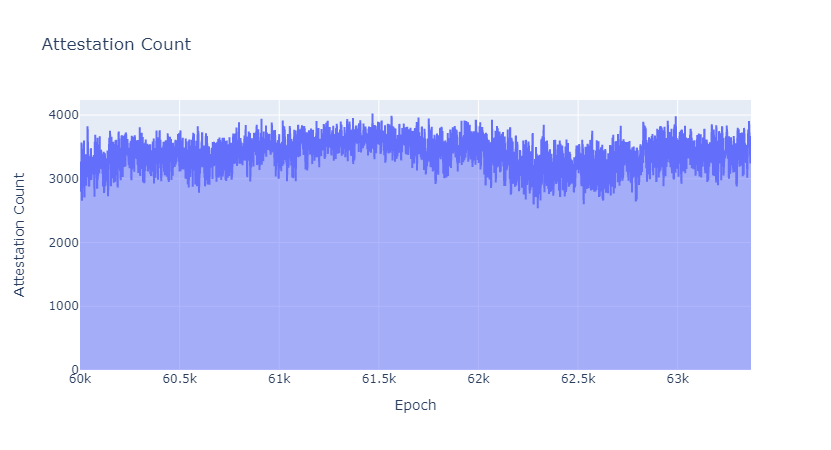

In [8]:
fig = px.area(df, x="epoch", y="attestation_count", title='Attestation Count', labels = {'epoch': 'Epoch', 'attestation_count': 'Attestation Count'})
fig.show()

In [9]:
df['attestation_count'].describe()

count    3369.000000
mean     3397.217869
std       248.510897
min      2536.000000
25%      3234.000000
50%      3421.000000
75%      3583.000000
max      4024.000000
Name: attestation_count, dtype: float64

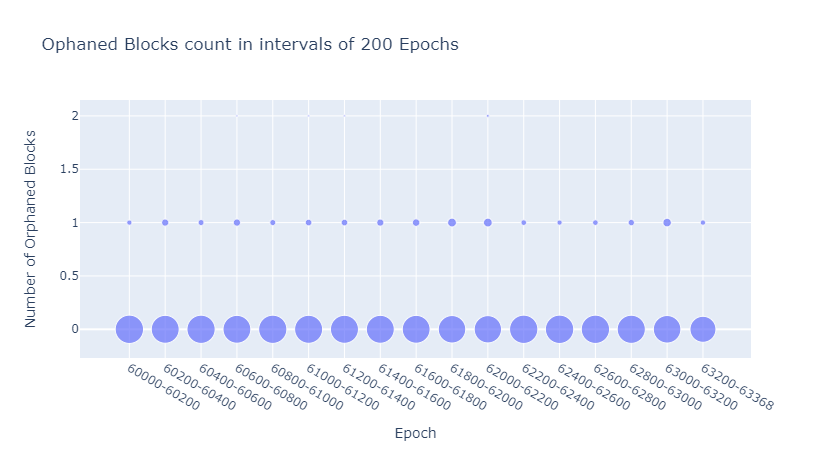

In [10]:
bucket_size = 200
df["bucket"] = np.floor_divide(df["epoch"], bucket_size)
df["n_bxs"] = 1
df_bucket = df[["bucket", "orphaned_blocks", "n_bxs"]].groupby(["bucket", "orphaned_blocks"]).sum("n_bxs").reset_index()
df_bucket["epoch"] = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)

fig = px.scatter(df_bucket, x = 'epoch', y = 'orphaned_blocks', size = 'n_bxs',
                 labels={ "orphaned_blocks": "Number of Orphaned Blocks", "epoch": "Epoch", "n_bxs": "Count" },
                 title = f"Ophaned Blocks count in intervals of {bucket_size} Epochs")
fig

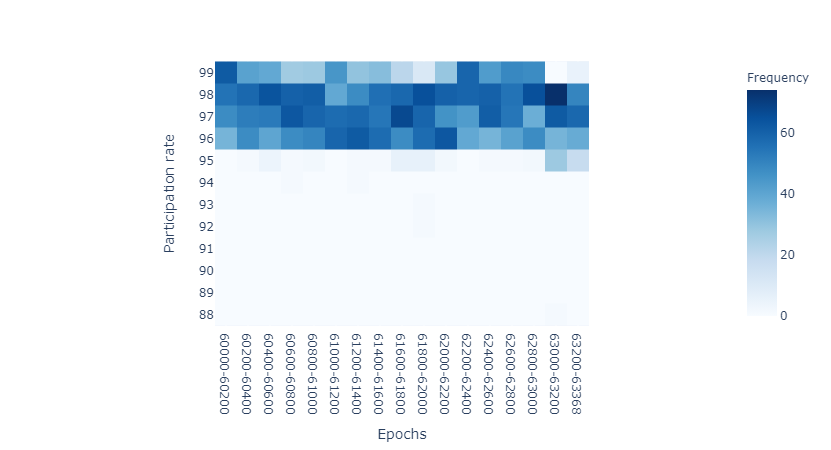

In [11]:
bucket_size = 200
df["bucket"] = np.floor_divide(df["epoch"], bucket_size)
df["n_bxs"] = 1
bins = pd.IntervalIndex.from_tuples([(i,i+1) for i in range(int(min(df["global_participation_rate"])), 100)][::-1])
df["participation_bin"] = pd.cut(df["global_participation_rate"], bins)
df_bucket = df[["bucket", "participation_bin", "n_bxs"]].groupby(["bucket", "participation_bin"]).sum("n_bxs").reset_index()
epoch_names = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)
df_bucket["epoch"] = epoch_names
df_bucket = df_bucket[["participation_bin", "n_bxs", "epoch"]].pivot(index="participation_bin", columns=["epoch"])

px.imshow(
    df_bucket.to_numpy(),
    labels=dict(x="Epochs", y="Participation rate", color="Frequency"),
    x = sorted(list(set(epoch_names))),
    y = [str(s) for s in np.flip(np.arange(int(min(df["global_participation_rate"])), 100))],
    color_continuous_scale='blues'
)

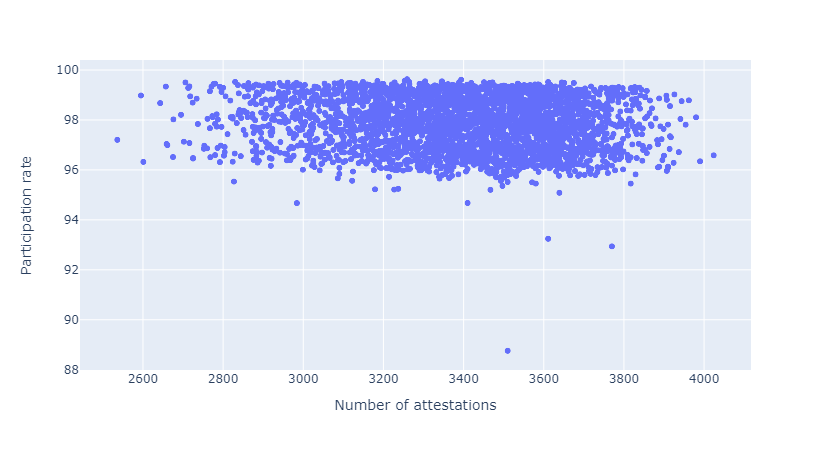

In [4]:
fig = px.scatter(x=df['attestation_count'], y=df['global_participation_rate'], labels=dict(x="Number of attestations", y="Participation rate"))
fig.show()

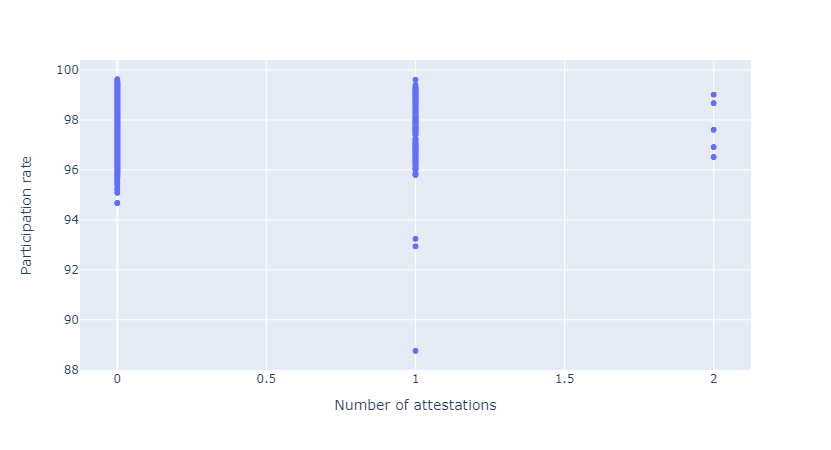

In [22]:
fig = px.scatter(x=df['orphaned_blocks'], y=df['global_participation_rate'], labels=dict(x="Number of attestations", y="Participation rate"))
fig.show()

In [18]:
x = df['orphaned_blocks']
y = df['global_participation_rate']

In [23]:
print('Pearsons r')
scipy.stats.pearsonr(x, y)    # Pearson's r

Pearsons r


(-0.04680421447191865, 0.006584834283055283)

In [24]:
print('Spearmans rho')
scipy.stats.spearmanr(x, y)   # Spearman's rho

Spearmans rho


SpearmanrResult(correlation=-0.03372956696005145, pvalue=0.0502771235009522)

In [25]:
print('Kendalls tau')
scipy.stats.kendalltau(x, y)  # Kendall's tau

Kendalls tau


KendalltauResult(correlation=-0.02752090730295159, pvalue=0.050319608422834464)

#### Takeaway: There is no real correlation between the increase in orphaned blocks and drop in global participation rate

In [ ]:
fig = px.scatter(x=df['orphaned_blocks'], y=df['global_participation_rate'], labels=dict(x="Number of orphaned blocks", y="Participation rate"))
fig.show()

## Question 2

### Data collection

In [30]:
l_validators = []
kr_validators = []
bi_validators = []
bs_validators = []
st_validators = []

In [31]:
address = ['a76a7d0d06754e4fc4941519d1f9d56fd9f8d53b', 'a40dfee99e1c85dc97fdc594b16a460717838703', 'e572d341fdb292f0bf8964f3ff9b0c2b9498f1c2', 'dd9663bd979f1ab1bada85e1bc7d7f13cafe71f8', '4069d8a3de3a72eca86ca5e0a4b94619085e7362']

In [32]:
x = requests.get('https://beaconcha.in/api/v1/validator/eth1/{}?api_key={}'.format(address[0], api_key))
data = x.json()['data']
for i in data:
    l_validators.append(i['validatorindex'])
    
x = requests.get('https://beaconcha.in/api/v1/validator/eth1/{}?api_key={}'.format(address[1], api_key))
data = x.json()['data']
for i in data:
    kr_validators.append(i['validatorindex'])
    
x = requests.get('https://beaconcha.in/api/v1/validator/eth1/{}?api_key={}'.format(address[2], api_key))
data = x.json()['data']
for i in data:
    bi_validators.append(i['validatorindex'])
    
x = requests.get('https://beaconcha.in/api/v1/validator/eth1/{}?api_key={}'.format(address[3], api_key))
data = x.json()['data']
for i in data:
    bs_validators.append(i['validatorindex'])
    
x = requests.get('https://beaconcha.in/api/v1/validator/eth1/{}?api_key={}'.format(address[4], api_key))
data = x.json()['data']
for i in data:
    st_validators.append(i['validatorindex'])

In [ ]:
# with open("lido.txt", "w") as output:
#     output.write(str(l_validators))
    
# with open("kraken.txt", "w") as output:
#     output.write(str(kr_validators))
    
# with open("binance.txt", "w") as output:
#     output.write(str(bi_validators))

# with open("bitcoin_suisse.txt", "w") as output:
#     output.write(str(bs_validators))

# with open("stkr.txt", "w") as output:
#     output.write(str(st_validators))

In [38]:
l_validators = random.sample(l_validators, 1000)
kr_validators = random.sample(kr_validators, 1000)
bi_validators = random.sample(bi_validators, 1000)
bs_validators = random.sample(bs_validators, 1000)
st_validators = random.sample(st_validators, 1000)

### Comparing missed, orphaned attestations

In [41]:
lido_missed = []
kraken_missed = []
binance_missed = []
bitcoin_suisse_missed = []
stkr_missed = []

In [42]:
lido_orphaned = []
kraken_orphaned = []
binance_orphaned = []
bitcoin_suisse_orphaned = []
stkr_orphaned = []

In [73]:
# for i in l_validators:
#     x = requests.get('https://beaconcha.in/api/v1/validator/stats/{}?api_key={}'.format(i, api_key))
#     sleep(6)
#     data = x.json()['data']
#     s = 0
#     t = 0
#     for j in data:
#         if j['missed_attestations'] != None:
#             s += j['missed_attestations'] 
#         if j['orphaned_attestations'] != None:
#             t += j['orphaned_attestations'] 
#     lido_missed.append(s)
#     lido_orphaned.append(t)

api_key = 'YUhrSzA2TkE2NUwyR3VzeWxXLzdl'
    
# for i in range(256,len(kr_validators)):
#     x = requests.get('https://beaconcha.in/api/v1/validator/stats/{}?api_key={}'.format(str(kr_validators[i]), api_key))
#     data = x.json()['data']
#     sleep(6)
#     s = 0
#     t = 0
#     for j in data:
#         if j['missed_attestations'] != None:
#             s += j['missed_attestations'] 
#         if j['orphaned_attestations'] != None:
#             t += j['orphaned_attestations'] 
#     kraken_missed.append(s)
#     kraken_orphaned.append(t)
    
for i in range(607,len(bi_validators)):
    x = requests.get('https://beaconcha.in/api/v1/validator/stats/{}?api_key={}'.format(str(bi_validators[i]), api_key))
    data = x.json()['data']
    sleep(6)
    s = 0
    t = 0
    for j in data:
        if j['missed_attestations'] != None:
            s += j['missed_attestations'] 
        if j['orphaned_attestations'] != None:
            t += j['orphaned_attestations'] 
    binance_missed.append(s)
    binance_orphaned.append(t)
    
for i in bs_validators:
    x = requests.get('https://beaconcha.in/api/v1/validator/stats/{}?api_key={}'.format(str(i), api_key))
    data = x.json()['data']
    sleep(6)
    s = 0
    t = 0
    for j in data:
        if j['missed_attestations'] != None:
            s += j['missed_attestations'] 
        if j['orphaned_attestations'] != None:
            t += j['orphaned_attestations'] 
    bitcoin_suisse_missed.append(s)
    bitcoin_suisse_orphaned.append(t)
    
for i in st_validators:
    x = requests.get('https://beaconcha.in/api/v1/validator/stats/{}?api_key={}'.format(str(i), api_key))
    data = x.json()['data']
    sleep(6)
    s = 0
    t = 0
    for j in data:
        if j['missed_attestations'] != None:
            s += j['missed_attestations'] 
        if j['orphaned_attestations'] != None:
            t += j['orphaned_attestations'] 
    stkr_missed.append(s)
    stkr_orphaned.append(t)

In [74]:
with open("lido_missed.txt", "w") as output:
    output.write(str(lido_missed))
with open("kraken_missed.txt", "w") as output:
    output.write(str(kraken_missed))
with open("binance_missed.txt", "w") as output:
    output.write(str(binance_missed))
with open("bitcoin_suisse_missed.txt", "w") as output:
    output.write(str(bitcoin_suisse_missed))
with open("stkr_missed.txt", "w") as output:
    output.write(str(stkr_missed))

In [75]:
with open("lido_orphaned.txt", "w") as output:
    output.write(str(lido_orphaned))
with open("kraken_orphaned.txt", "w") as output:
    output.write(str(kraken_orphaned))
with open("binance_orphaned.txt", "w") as output:
    output.write(str(binance_orphaned))
with open("bitcoin_suisse_orphaned.txt", "w") as output:
    output.write(str(bitcoin_suisse_orphaned))
with open("stkr_orphaned.txt", "w") as output:
    output.write(str(stkr_orphaned))

In [84]:
lido_ae = []
kraken_ae = []
binance_ae = []
bitcoin_suisse_ae = []
stkr_ae = []

In [85]:
for i in range(0,1000,100):
    
    str1 = ''
    #str2 = ''

    for j in range(99):
        if l_validators[i+j] != None:
            str1 = str1 + str(l_validators[i+j]) + ','
        #str2 = str2 + str(i+j) + ','
    
    str1 = str1 + str(l_validators[i+99])
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/attestationeffectiveness?api_key={}'.format(str1, api_key))
    sleep(6)
    data = x.json()['data']
    
    for i in data:
        lido_ae.append(i['attestation_effectiveness'])     
        
for i in range(0,1000,100):
    
    str1 = ''
    #str2 = ''

    for j in range(99):
        if kr_validators[i+j] != None:
            str1 = str1 + str(kr_validators[i+j]) + ','
        #str2 = str2 + str(i+j) + ','
    
    str1 = str1 + str(kr_validators[i+99])
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/attestationeffectiveness?api_key={}'.format(str1, api_key))
    sleep(6)
    data = x.json()['data']
    
    for i in data:
        kraken_ae.append(i['attestation_effectiveness'])  
        
for i in range(0,1000,100):
    
    str1 = ''
    #str2 = ''

    for j in range(99):
        if bi_validators[i+j] != None:
            str1 = str1 + str(bi_validators[i+j]) + ','
        #str2 = str2 + str(i+j) + ','
    
    str1 = str1 + str(bi_validators[i+99])
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/attestationeffectiveness?api_key={}'.format(str1, api_key))
    sleep(6)
    data = x.json()['data']
    
    for i in data:
        binance_ae.append(i['attestation_effectiveness'])  
        
for i in range(0,1000,100):
    
    str1 = ''
    #str2 = ''

    for j in range(99):
        if bs_validators[i+j] != None:
            str1 = str1 + str(bs_validators[i+j]) + ','
        #str2 = str2 + str(i+j) + ','
    
    str1 = str1 + str(bs_validators[i+99])
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/attestationeffectiveness?api_key={}'.format(str1, api_key))
    sleep(6)
    data = x.json()['data']
    
    for i in data:
        bitcoin_suisse_ae.append(i['attestation_effectiveness'])  
        
for i in range(0,1000,100):
    
    str1 = ''
    #str2 = ''

    for j in range(99):
        if st_validators[i+j] != None:
            str1 = str1 + str(st_validators[i+j]) + ','
        #str2 = str2 + str(i+j) + ','
    
    str1 = str1 + str(st_validators[i+99])
    x = requests.get('https://beaconcha.in/api/v1/validator/{}/attestationeffectiveness?api_key={}'.format(str1, api_key))
    sleep(6)
    data = x.json()['data']
    
    for i in data:
        stkr_ae.append(i['attestation_effectiveness'])  

In [86]:
with open("lido_ae.txt", "w") as output:
    output.write(str(lido_ae))
with open("kraken_ae.txt", "w") as output:
    output.write(str(kraken_ae))
with open("binance_ae.txt", "w") as output:
    output.write(str(binance_ae))
with open("bitcoin_suisse_ae.txt", "w") as output:
    output.write(str(bitcoin_suisse_ae))
with open("stkr_ae.txt", "w") as output:
    output.write(str(stkr_ae))

### Missed Attestations in the last 285 days

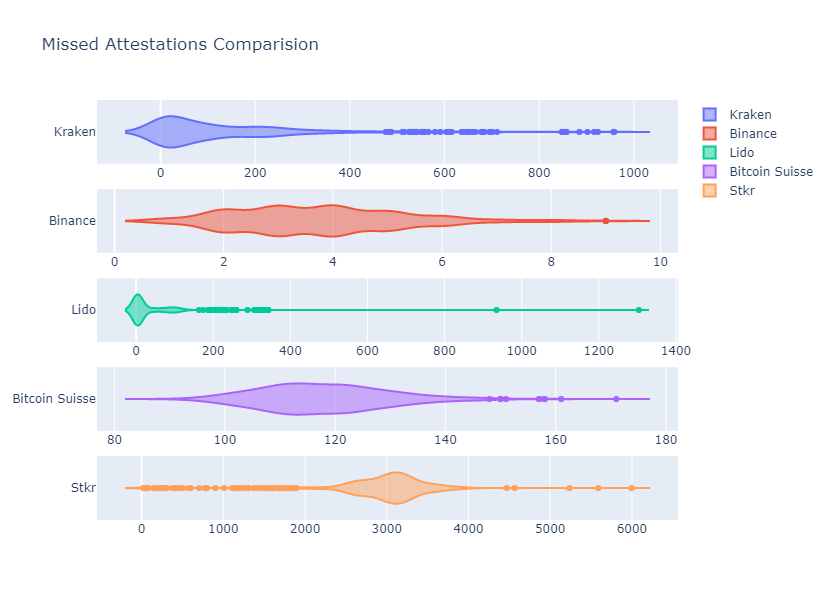

In [13]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=1)

fig.append_trace(go.Violin(
    name = 'Kraken',
    x=kraken_missed,
), row=1, col=1)

fig.append_trace(go.Violin(
    name = 'Binance',
    x=binance_missed,
), row=2, col=1)

fig.append_trace(go.Violin(
    name = 'Lido',
    x=lido_missed,
), row=3, col=1)

fig.append_trace(go.Violin(
    name = 'Bitcoin Suisse',
    x=bitcoin_suisse_missed,
), row=4, col=1)


fig.append_trace(go.Violin(
    name = 'Stkr',
    x=stkr_missed,
), row=5, col=1)


# fig.update_xaxes(range=[35000000, 105000000])

fig.update_layout(height=600, width=600, title_text="Missed Attestations Comparision")
fig.show()

#### Kraken

In [16]:
pd.Series(kraken_missed).describe()

count    1000.000000
mean      129.826000
std       164.968167
min         0.000000
25%        12.750000
50%        74.000000
75%       197.250000
max       959.000000
dtype: float64

#### Binance

In [17]:
pd.Series(binance_missed).describe()

count    1000.000000
mean        3.737000
std         1.525174
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         9.000000
dtype: float64

#### Lido

In [18]:
pd.Series(lido_missed).describe()

count    1000.000000
mean       42.972000
std        82.864321
min         0.000000
25%         1.000000
50%         7.000000
75%        64.500000
max      1304.000000
dtype: float64

#### Bitcoin Suisse

In [19]:
pd.Series(bitcoin_suisse_missed).describe()

count    1000.000000
mean      118.056000
std        11.569647
min        88.000000
25%       110.000000
50%       117.000000
75%       125.000000
max       171.000000
dtype: float64

#### Stkr

In [20]:
pd.Series(stkr_missed).describe()

count    1000.000000
mean     2884.019000
std       717.891704
min        22.000000
25%      2702.500000
50%      3041.000000
75%      3239.250000
max      5996.000000
dtype: float64

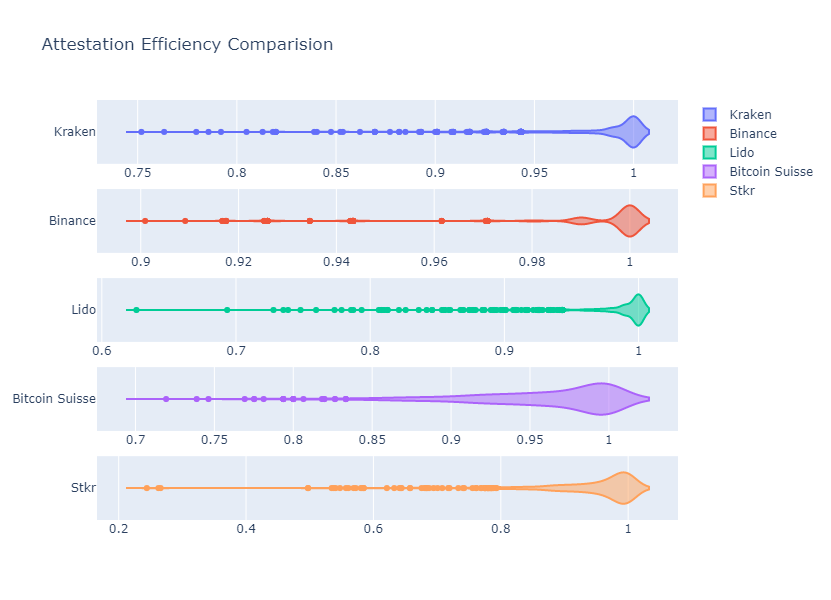

In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=1)

fig.append_trace(go.Violin(
    name = 'Kraken',
    x=kraken_ae,
), row=1, col=1)

fig.append_trace(go.Violin(
    name = 'Binance',
    x=binance_ae,
), row=2, col=1)

fig.append_trace(go.Violin(
    name = 'Lido',
    x=lido_ae,
), row=3, col=1)

fig.append_trace(go.Violin(
    name = 'Bitcoin Suisse',
    x=bitcoin_suisse_ae,
), row=4, col=1)


fig.append_trace(go.Violin(
    name = 'Stkr',
    x=stkr_ae,
), row=5, col=1)


# fig.update_xaxes(range=[35000000, 105000000])

fig.update_layout(height=600, width=600, title_text="Attestation Efficiency Comparision")
fig.show()